# **HOMEWORK 2**

*   **Run following cells to mount drive and import all necessary dependencies**

In [97]:
# Mount Drive
#from google.colab import drive
#drive.mount('/content/drive')

# path to store the data
#%cd /content/drive/My Drive/DL4NLP_2024/

In [98]:
# Import Dependencies

!pip install datasets
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')

from scipy.stats import pearsonr, kendalltau

from pprint import pprint

import matplotlib.pyplot as plt

import gdown

[nltk_data] Downloading package punkt to /home/steinerj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [99]:
# Specify random seed

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# **Task 1: Getting to Know Pytorch: Semantic Textual Similarity**

In this task, we define semantic textual similarity (STS) as a supervised regression task in which the semantic similarity of two pieces of text (typically sentences) should be determined.

### **Task 1.1: Data Preparation**

First we should load the dataset for this task. Each entry of this dataset contains one English sentence pair and their similarity score. The data is structured like both Python dictionary and Pandas DataFrame.
*   **Run the following cell to load the dataset:**


In [100]:
train_set = load_dataset("stsb_multi_mt", "en", split='train')
dev_set = load_dataset("stsb_multi_mt", "en", split='dev')

dev_set

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1500
})

**a)** To get familiar with the data format, print following information:
*  **The first entry of `train_set`**
*  **the size of `dev_set`**
*  **the first 3 `sentence1` in `train_set`**


In [101]:
# TODO: YOUR CODE HERE
print(f"First entry of train_set: {train_set[0]}")
print(f"Size of dev_set: {len(dev_set)}")
print(f"First 3 sentence1 in train_set: {train_set[:3]['sentence1']}")

First entry of train_set: {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
Size of dev_set: 1500
First 3 sentence1 in train_set: ['A plane is taking off.', 'A man is playing a large flute.', 'A man is spreading shreded cheese on a pizza.']


## **Task 1.1.1: Sentence Embedding with FastText**
We will use the averages of the words using [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) to embed both sentences.

* **Run the following cell to download the embeddings.**

In [102]:
# download word emebddings to your drive and unzip the file (run this cell only when you haven't downloaded the emb file yet.)
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# !unzip wiki-news-300d-1M.vec.zip

**b)**    **Implement the function** `load _embeddings` to read the word embeddings into a Python dictionary that maps every token to the corresponding vector and returns word embeddings. Represent the vectors as Numpy arrays. Only load the embeddings of the first 30,000 tokens in the file

In [103]:
def load_embeddings(file="wiki-news-300d-1M.vec"):
	with open(file, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
		_ = f.readline()
		data = {}
		for line in f:
			tokens = line.rstrip().split(' ')
			data[tokens[0]] = np.asanyarray(tokens[1:], dtype=np.float32)
			if len(data) == 30000:
				break
		
		return data


**c)**   **Print** the size of the dictionary and the first 10 dimensions of the embedding for the word "Frequency".

In [125]:
# TODO: YOUR CODE HERE
emb = load_embeddings()
print(len(emb))
print(emb["Frequency"][0:10])

30000
[-0.1752  0.0877  0.0047  0.0691 -0.0453 -0.2031 -0.2423  0.1085  0.092
  0.1646]



**d)**  **Implement a function** `tokenize` that tokenizes a sentence using nltk.word_tokenize and returns a list of tokens for given sentence.



In [105]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)   

**e)**  **Print** the tokenized `sentence1` and `sentence2` of the 20th entry in the training set.

In [106]:
# TODO: YOUR CODE HERE
sentence1 = train_set[20]['sentence1']
sentence2 = train_set[20]['sentence2']

pprint(tokenize(sentence1))
pprint(tokenize(sentence2))

['A', 'man', 'pours', 'oil', 'into', 'a', 'pot', '.']
['A', 'man', 'pours', 'wine', 'in', 'a', 'pot', '.']


**f)** **Implement a function** `embed_sentence` that maps a sentence to its embedding. The sentence-level embedding should be the average of the embeddings of its tokens. If a token does not exist in the vocabulary of FastText, embed this token as a 0-vector with the same dimensions as the FastText embeddings.



In [127]:
def embed_sentence(sentence, word2emb):
    embedding_vectors = [word2emb[token] if token in word2emb else np.zeros((300,)) for token in tokenize(sentence)]
    return np.mean(embedding_vectors, axis=0)

**g)**  **Print** the shape and the first 10 dimensions of `sentence1`'s embedding of the 20th entry in the training set.

In [128]:
sentence_embedding = embed_sentence(train_set[20]['sentence1'], emb)

print(sentence_embedding.shape)
print(sentence_embedding[0:10])

(300,)
[-0.03605   -0.0061875  0.0339    -0.0033625 -0.0274375 -0.0258125
  0.0595    -0.039825  -0.06175   -0.037025 ]


## **Task 1.1.2: Build Custom Dataset**


* **Implement a custom dataset class** `MLPDataset` inheriting `torch.utils.data.Dataset` and override the following methods:
  1.   `__len__`: which returns the size of the dataset.
  2.   `__getitem__`: to support the indexing such that dataset[i] can be used to get ith sample.
  
      The ith sample should be a Python dict with two entries:
    * ` encoding`: the encoding of one sentence pair, which is the concatenation of the embeddings of the two sentences of a pair. E.g., sent1 = [1,2], sent2 = [3,4], the encoding for sent1 and sent2 should be [1,2,3,4].
    *   `score `: the similarity score between the two sentences.
Hint: examples can be found here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html





In [131]:
class MLPDataset(Dataset):
  def __init__(self, sents_1, sents_2, scores):
    """
    Arguments:
      sents_1 (List[string]): the list of the first sentences.
      sents_2 (List[string]): the list of the second sentences.
      scores (List[float]): the list of the similarity scores.
    """
    self.sents_1 = sents_1
    self.sents_2 = sents_2
    self.scores = scores

  def __getitem__(self, idx):
    return {
      'encoding': torch.cat(
        	(
          		torch.tensor(embed_sentence(self.sents_1[idx], emb), dtype=torch.float),
          		torch.tensor(embed_sentence(self.sents_2[idx], emb), dtype=torch.float)
        	)
    	),
      'score': torch.tensor(float(self.scores[idx]), dtype=torch.float)
    }

  def __len__(self):
    assert len(self.sents_1) == len(self.sents_2) and len(self.sents_2) == len(self.scores)
    return len(self.sents_1)

**h)**  **Instantiate** the above class for our `train_set` and `dev_set`.

In [132]:
# TODO: YOUR CODE HERE
mlp_train_set = MLPDataset(
    sents_1=train_set['sentence1'],
    sents_2=train_set['sentence2'],
    scores=train_set['similarity_score']
)

mlp_dev_set = MLPDataset(
    sents_1=dev_set['sentence1'],
    sents_2=dev_set['sentence2'],
    scores=dev_set['similarity_score']
)

**i)**  **Print** the size of `dev_dataset` and the shape of the encoding of the first example.

In [133]:
print(f"Size: {len(mlp_dev_set)}")
print(mlp_dev_set[0]['encoding'].shape)

Size: 1500
torch.Size([600])


## **Task 1.2: Scoring the Similarity**
We will train a simple multi-layer perceptron (MLP) to score the similarity of the two sentences.

### **Task 1.2.1: Build MLP using Pytorch**

We will use [`pytorch.nn`](https://pytorch.org/docs/stable/nn.html) to build our MLP.

**a)** **Implement a class** `MLP` inheriting [`pytorch.nn.Module`]() for our MLP, which has the following components:

- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 900 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) with probability 0.2.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.2.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.2.
- A linear layer with 1 dimension (output layer).

**Hint**:
- You need to override the method `forward` in this class
- Use `nn.Sequential` to sequentialize the layers.
- You may want to see a quick example: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html?highlight=sequential


In [134]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(600, 900),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(900, 600),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(600, 600),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(600, 1)
    )

  def forward(self, x):
    return self.layers(x)

**b)**  **Initialize the** `model`of this class and **print** it

In [135]:
mlp = MLP()
pprint(mlp)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=600, out_features=900, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=900, out_features=600, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=600, out_features=600, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=600, out_features=1, bias=True)
  )
)


### **Task 1.2.2: Train MLP with Pytorch**


The method for training is provided below, which returns the list of the train loss at all epochs and the trained model.
*  **Run the code below**

In [114]:
def train(model, train_dataloader, eval_dataloader, optimizer, loss_fn, num_epochs, device='cuda'):

  train_losses = []

  for epoch in range(num_epochs):

    if epoch == 0:
      model.eval()
      loss_per_epoch = 0
      for batch_data in train_dataloader:
        with torch.no_grad():
          predictions = model(batch_data['encoding'].to(device))
          targets = batch_data['score'].to(device) # only if device='cuda'
          train_loss = loss_fn(predictions.squeeze(), targets)
          loss_per_epoch += train_loss.item()
      loss_per_epoch = loss_per_epoch/len(train_dataloader)
      train_losses.append(loss_per_epoch)
      print(f'\ninital train loss: {loss_per_epoch}')

    model.train()
    loss_per_epoch = 0
    for batch_data in train_dataloader:
      predictions = model(batch_data['encoding'].to(device))
      targets = batch_data['score'].to(device) # only if device='cuda'
      train_loss = loss_fn(predictions.squeeze(), targets)
      loss_per_epoch += train_loss.item()

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    loss_per_epoch = loss_per_epoch/len(train_dataloader)
    train_losses.append(loss_per_epoch)
    print(f'\n Epoch {epoch+1} train loss: {loss_per_epoch}')
    #evaluate(model, eval_dataloader, loss_func)

  return train_losses, model

**c)** **Define the corresponding hyperparameters**
  *   Number of training epochs are 15
  *   Batch Size is 128
  *   Learning Rate is 2e-03



In [115]:
# Set random seeds; do not change this!
seed_everything(seed=999)

num_epochs = 15
batch_size = 128
lr = 2e-03


**d)**   **Create Dataloaders** considering following information
  * `train_dataloader` : reshuffle at every epoch
  * `dev_dataloader` : batch size is 512

**Hint:** batch size of train dataloader is different than dev dataloader


In [136]:
train_dataloader = DataLoader(
    dataset=mlp_train_set,
    batch_size=batch_size,
    shuffle=True
)

dev_dataloader = DataLoader(
    dataset=mlp_dev_set,
    batch_size=512
)


**e)**   **Define** Optimizer as AdmW and Loss function as Mean Square Error

In [137]:
# Initialize the model
device = "cpu"
model = MLP()
model.to(device)

optimizer =  torch.optim.AdamW(
    params=model.parameters(),
    lr=lr
)

loss_func = torch.nn.MSELoss()



**f)**   Use the train function with the hyperparameters above to **store training losses and the model** in variables called:
  * `train_losses`
  * `model`



In [138]:
train_loss, model = train(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=dev_dataloader,
    optimizer=optimizer,
    loss_fn=loss_func,
    num_epochs=num_epochs,
    device=device
)


inital train loss: 9.376733186509874

 Epoch 1 train loss: 3.3059159172905814

 Epoch 2 train loss: 2.00763381852044

 Epoch 3 train loss: 1.9089261478847928

 Epoch 4 train loss: 1.822142571873135

 Epoch 5 train loss: 1.713505138291253

 Epoch 6 train loss: 1.6026625792185465

 Epoch 7 train loss: 1.4412372138765124

 Epoch 8 train loss: 1.2957790613174438

 Epoch 9 train loss: 1.165720940960778

 Epoch 10 train loss: 1.0580856733851962

 Epoch 11 train loss: 0.9259650230407714

 Epoch 12 train loss: 0.8102189885245429

 Epoch 13 train loss: 0.7382241871621874

 Epoch 14 train loss: 0.667118654648463

 Epoch 15 train loss: 0.5849045508437687


**g)** **Plot** the training loss using `matplotlib.pyplot.plot` (Plotting takes time - consider waiting!)


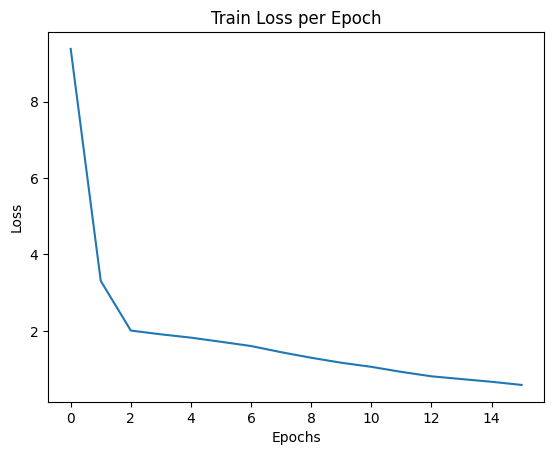

In [144]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss per Epoch")
    plt.show()


plot_losses(train_loss)

**h)** **Implement** another MLP architecture using [`pytorch.nn.Module`](), which has the following components:
- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 1,200 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A linear layer with 300 dimensions and relu activation.
- A linear layer with 300 dimensions and relu activation.
- A linear layer with 1 dimension (output layer).

In [140]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(600, 1200),
      nn.ReLU(),
      nn.Linear(1200, 300),
      nn.ReLU(),
      nn.Linear(300, 300),
      nn.ReLU(),
      nn.Linear(300, 1)
    )

  def forward(self, x):
    return self.layers(x)

**i)** **Initialize and train** the new class with the function from above

In [141]:
model = MLP()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train_losses_second_model, model = train(model, train_dataloader, dev_dataloader, optimizer, loss_func, num_epochs, device)


inital train loss: 9.71240717569987

 Epoch 1 train loss: 2.7842648665110272

 Epoch 2 train loss: 1.9658077902264066

 Epoch 3 train loss: 1.8212649742762248

 Epoch 4 train loss: 1.7414042605294122

 Epoch 5 train loss: 1.5628756417168512

 Epoch 6 train loss: 1.396387137307061

 Epoch 7 train loss: 1.1840546939108108

 Epoch 8 train loss: 1.033374003569285

 Epoch 9 train loss: 0.8553506990273794

 Epoch 10 train loss: 0.7218878481123182

 Epoch 11 train loss: 0.5824495434761048

 Epoch 12 train loss: 0.4957239740424686

 Epoch 13 train loss: 0.38628680838478935

 Epoch 14 train loss: 0.3124388807349735

 Epoch 15 train loss: 0.24580783049265545


**j)** **Plot** the loss curve both the first and the second model (you can reuse your code from above)

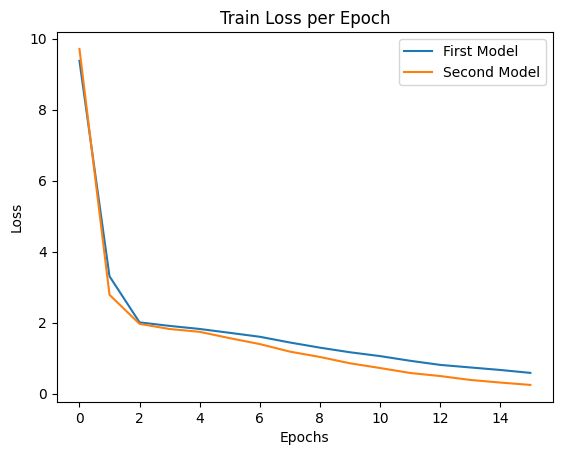

In [146]:
def plot_losses_comparison(first_losses, second_losses):
    plt.plot(first_losses, label="First Model")
    plt.plot(second_losses, label="Second Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss per Epoch")
    plt.legend()
    plt.show()


plot_losses_comparison(train_loss, train_losses_second_model)

**k)** **Compare** the difference in the architectures and their corresponding losses. Describe what might have caused these changes.

The first model has less nodes in the first layer but more nodes in the following layers compared to the second model. Additionally, the first model uses dropout regularization after each ReLU activation function. 

The initial loss is the same for both models. The final loss is only 50% of the final loss of the first model. This could be caused by the dropout layers used in the first model.

Dropout regularization tries to avoid overfitting by improving generalization of the model which might cause the higher training loss in the first model.